In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, classification_report

In [2]:
iris = datasets.load_iris()

# See the key values
print("\nKey Values: \n", list(iris.keys()))

# The feature names
print("\nFeature Names: \n", list(iris.feature_names))

# The target names
print("\nTarget Names: \n", list(iris.target_names))

# The target values (codes)
print("\nTarget Values: \n", list(iris.target))


Key Values: 
 ['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename']

Feature Names: 
 ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

Target Names: 
 ['setosa', 'versicolor', 'virginica']

Target Values: 
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [3]:
# Data Matrix
X = iris["data"]

# Target Vector
y = (iris["target"] == 2).astype(np.int)  # 1 if Iris-Virginica, else 0

print(X.shape)
print(y.shape)

(150, 4)
(150,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [6]:
# Set the the range of K 
neighbors = np.arange(1,60)

# Two arrays to store training and test accuracies
train_accuracy = np.empty(len(neighbors))
validation_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    
    # Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Fit the model
    knn.fit(X_train, y_train)
    
    
    # The "score" function returns the mean accuracy on the given train/test data and labels.
    # Note that "accuracy" may not be a good performance measure in a skewed data set
    # Thus, we need to do hyperparameter tuning by using better performance measures (e.g., f1 score, presision, recall)
    
    # Compute training accuracy 
    train_accuracy[i] = knn.score(X_train, y_train)
    
    # Compute validation accuracy using cross-validation
    
    scores = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=5)
    
    validation_accuracy[i] = scores.mean()

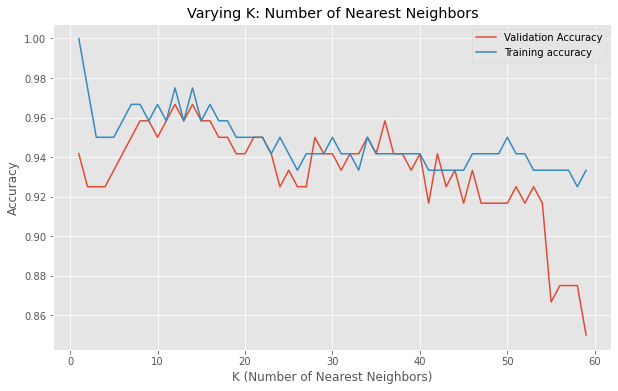

Optimal K:  12


In [7]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 6))
plt.title('Varying K: Number of Nearest Neighbors')
plt.plot(neighbors, validation_accuracy, label='Validation Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('K (Number of Nearest Neighbors)')
plt.ylabel('Accuracy')
plt.show()



# Find the value of "K" that gives max validation accuracy
j = 0
max_val_accuracy = validation_accuracy[j]
max_k = 1

for i in neighbors:
    if(validation_accuracy[j] > max_val_accuracy):
        max_val_accuracy = validation_accuracy[j]
        max_k = i
    j +=1
    
print("Optimal K: ", max_k)

In [8]:
%%time

warnings.filterwarnings('ignore')

# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values
param_grid = {'n_neighbors': np.arange(1,50), 'p': [1, 2, 10, 50, 100, 500, 1000], 
              'weights': ["uniform", "distance"]}

knn_clf = KNeighborsClassifier()

knn_cv = GridSearchCV(knn_clf, param_grid, scoring='f1', cv=5, verbose=3, n_jobs=-1)
knn_cv.fit(X_train, y_train)


params_optimal_knn = knn_cv.best_params_

print("Best Score: %f" % knn_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_knn)
print("\n")

Fitting 5 folds for each of 686 candidates, totalling 3430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 2312 tasks      | elapsed:    4.5s


Best Score: 0.955487
Optimal Hyperparameter Values:  {'n_neighbors': 8, 'p': 50, 'weights': 'uniform'}


CPU times: user 1.3 s, sys: 107 ms, total: 1.41 s
Wall time: 6.05 s


[Parallel(n_jobs=-1)]: Done 3430 out of 3430 | elapsed:    6.0s finished


In [9]:
knn = KNeighborsClassifier(**params_optimal_knn)

knn.fit(X_train, y_train)

y_train_predicted = knn.predict(X_train)

train_accuracy_knn = np.mean(y_train_predicted == y_train)
print("\nTraining Accuracy: ", train_accuracy_knn)


Training Accuracy:  0.975


In [10]:
scores = cross_val_score(knn, X_train, y_train, scoring='f1', cv=5)
print(scores)

print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.94736842 0.94117647 1.         1.         0.88888889]
F1 Score: 0.96 (+/- 0.08)


In [11]:
y_train_pred = cross_val_predict(knn, X_train, y_train, cv=5)

confusion_matrix(y_train, y_train_pred)

array([[73,  3],
       [ 1, 43]])

In [13]:
precision = precision_score(y_train, y_train_pred) 
print("Precision = %f" % precision)

recall = recall_score(y_train, y_train_pred)
print("Recall = %f" % recall)


f1 = f1_score(y_train, y_train_pred)
print("F1 Score = %f" % f1)

Precision = 0.934783
Recall = 0.977273
F1 Score = 0.955556


In [14]:
y_scores = cross_val_predict(knn, X_train, y_train, method="predict_proba", cv=5)[:, 1]


fpr, tpr, thresholds = roc_curve(y_train, y_scores)

print("\nFPR FPR & TPR for Various Threshold Values:")

print("FPR: ", fpr)
print("TPR: ", tpr)
print("\nThresholds: ", thresholds)


FPR FPR & TPR for Various Threshold Values:
FPR:  [0.         0.         0.01315789 0.01315789 0.03947368 0.06578947
 0.07894737 0.14473684 0.18421053 1.        ]
TPR:  [0.         0.68181818 0.77272727 0.86363636 0.97727273 0.97727273
 0.97727273 0.97727273 0.97727273 1.        ]

Thresholds:  [2.    1.    0.875 0.75  0.625 0.5   0.375 0.25  0.125 0.   ]


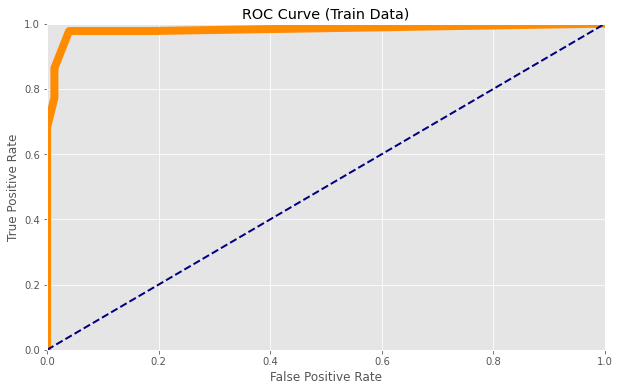

In [15]:
plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))
def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, color='darkorange', linewidth=8, label=label) 
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.axis([0, 1, 0, 1])
    plt.title('ROC Curve (Train Data)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [16]:
roc_auc_score(y_train,y_scores)

0.9817583732057416

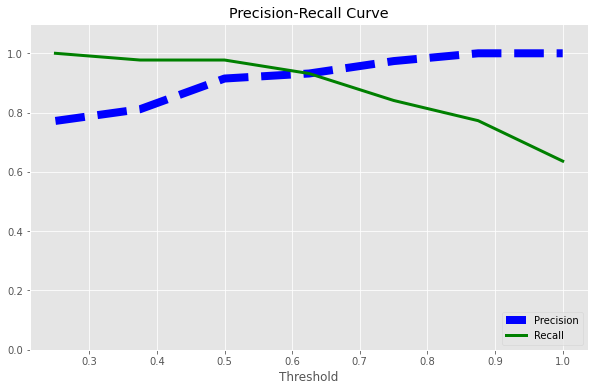

Optimal Threshold:  0.625


In [17]:
plt.style.use('ggplot')

# Get the 2nd column of the matrix of predicted probabilities for each data point
#    The 2nd column stores the probalities of the positive class
y_scores = cross_val_predict(knn, X_train, y_train, method="predict_proba", cv=3)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)


fig = plt.figure(figsize=(10, 6))
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.plot(thresholds, precisions[:-1], "b--",  linewidth=8, label="Precision") 
    plt.plot(thresholds, recalls[:-1], "g-",  linewidth=3, label="Recall") 
    plt.xlabel("Threshold")
    plt.legend(loc="lower right")
    plt.title('Precision-Recall Curve')
    #plt.xlim([0, 1])
    plt.ylim([0, 1.1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()


threshold_optimal = -1
for i in range(len(precisions)):
    if(precisions[i] == recalls[i]):
        threshold_optimal = thresholds[i]

print("Optimal Threshold: ", threshold_optimal)

In [18]:
print("Performance Measures Based on the Default Threshold:\n")


y_train_pred = cross_val_predict(knn, X_train, y_train, cv=5)

# Precision, Recall, F1 Score and Confusion Matrix for the Default Threshold 0.5
precision_train = precision_score(y_train, y_train_pred) 
print("Precision (Default Threshold 0.5) = %f" % precision_train)

recall_train = recall_score(y_train, y_train_pred)
print("Recall (Default Threshold 0.5) = %f" % recall_train)


f1_train = f1_score(y_train, y_train_pred)
print("F1 Score (Default Threshold 0.5) = %f" % f1_train)

print("Confusion Matrix (Default Threshold 0.5)\n", confusion_matrix(y_train, y_train_pred))


print("\n-------------------------------------------------------\n")
print("Performance Measures Based on the Optimal Threshold (from Precision-Recall Curve):")

# Precision, Recall, F1 Score and Confusion Matrix for different threshold

t = threshold_optimal # optimal threshold from precision-recall curve 

# Compute predictions based on new t by using the following method:
#  - Get the probability of the positive class from the 2nd column [:, 1]
#  - If that probability is greater than or equal to t, then the test data belongs to the positive class
y_train_predicted_new = (cross_val_predict(knn, X_train, y_train, method="predict_proba", cv=3)[:,1] > t).astype(int)


precision = precision_score(y_train, y_train_predicted_new) 
print("\nPrecision (Threshold %.2f) = %f" % (t, precision))

recall = recall_score(y_train, y_train_predicted_new)
print("Recall (Threshold %.2f) = %f" % (t, recall))


f1 = f1_score(y_train, y_train_predicted_new)
print("F1 Score = (Threshold %.2f) = %f" % (t, f1))


print("Confusion Matrix (Threshold %.2f)" %  t) 
print(confusion_matrix(y_train, y_train_predicted_new))

Performance Measures Based on the Default Threshold:

Precision (Default Threshold 0.5) = 0.934783
Recall (Default Threshold 0.5) = 0.977273
F1 Score (Default Threshold 0.5) = 0.955556
Confusion Matrix (Default Threshold 0.5)
 [[73  3]
 [ 1 43]]

-------------------------------------------------------

Performance Measures Based on the Optimal Threshold (from Precision-Recall Curve):

Precision (Threshold 0.62) = 0.973684
Recall (Threshold 0.62) = 0.840909
F1 Score = (Threshold 0.62) = 0.902439
Confusion Matrix (Threshold 0.62)
[[75  1]
 [ 7 37]]


In [19]:
test_accuracy_knn = knn.score(X_test, y_test)
print("\nTest Accuracy: ", test_accuracy_knn)


# No. of Correct Predictions
y_test_predicted = knn.predict(X_test)
print("\nNo. of correct predictions (Test): %d/%d" % (np.sum(y_test_predicted == y_test), len(y_test)))



# Confusion Matrix
print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test, y_test_predicted))


Test Accuracy:  1.0

No. of correct predictions (Test): 30/30

Confusion Matrix (Test Data):
 [[24  0]
 [ 0  6]]


In [20]:
precision = precision_score(y_test, y_test_predicted) 
print("Precision = %f" % precision)

recall = recall_score(y_test, y_test_predicted)
print("Recall = %f" % recall)


f1 = f1_score(y_test, y_test_predicted)
print("F1 Score = %f" % f1)

Precision = 1.000000
Recall = 1.000000
F1 Score = 1.000000


In [21]:
y_scores_test = cross_val_predict(knn, X_test, y_test, method="predict_proba", cv=3)[:, 1]

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_scores_test)


print("\nFPR FPR & TPR for Various Threshold Values:")
print("FPR: ", fpr_test)
print("TPR: ", tpr_test)
print("\nThresholds: ", thresholds_test)


FPR FPR & TPR for Various Threshold Values:
FPR:  [0.         0.         0.25       0.41666667 1.        ]
TPR:  [0.         0.66666667 0.83333333 1.         1.        ]

Thresholds:  [1.5   0.5   0.25  0.125 0.   ]


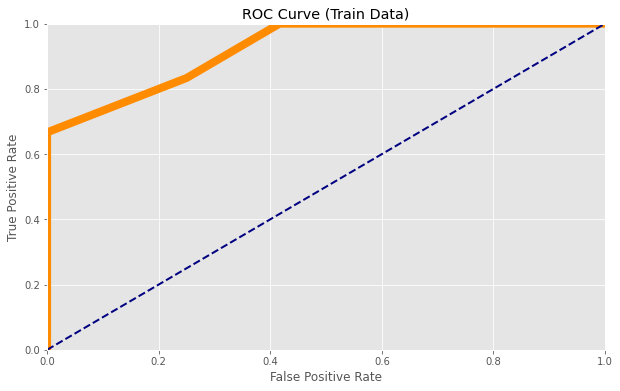

In [22]:
plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))
plot_roc_curve(fpr_test, tpr_test)
plt.show()

In [23]:
roc_auc_score(y_test,y_scores_test)

0.923611111111111

In [25]:
pd.crosstab(y_test, y_test_predicted, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,24,0,24
1,0,6,6
All,24,6,30


In [26]:
print(classification_report(y_test,y_test_predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00         6

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

